In [33]:
import pandas as pd
import numpy as np
import re
import pickle
import requests
from bs4 import BeautifulSoup
from datetime import date
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from transformers import TextClassificationPipeline
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [34]:
# LSTM 토크나이저
with open('./src/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)  
# LSTM 모델
model = load_model('./src/model.h5')
# BERT 토크나이저, 모델
loaded_tokenizer = BertTokenizerFast.from_pretrained('./src/bert', from_pt=True)
loaded_model = TFBertForSequenceClassification.from_pretrained('./src/bert', from_pt=True)
classifier = TextClassificationPipeline(tokenizer=loaded_tokenizer, model=loaded_model,
                                            framework='tf', return_all_scores=True) 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [3]:
df = pd.read_csv('./src/comments_naver_year.csv')
df

,날짜,댓글
0,2022-05-26,30 평단 언제 올까
1,2022-05-26,최고가에 못팔아 먹더니?
2,2022-05-26,내평단
3,2022-05-26,26년차)벌써 한장 벌고 있데이~♡
4,2022-05-26,잠시나마.
...,...,...
37799,2021-04-01,"한투연 입니다.(공매도 제도개선, 금융적..."
37800,2021-04-01,그냥 둘다 사
37801,2021-04-01,여러분 기억 앞에 겸손합시다 !
37802,2021-04-01,문간첩이 주주의결권 폐지한답니다


In [12]:
def konlpy_okt(df):
    okt = Okt()
    tag_list = ['Noun','Verb','Adjective','VerbPrefix'] 
    comment_list = df['댓글'].to_list()
    tokenized_data = []
    for i in range(len(comment_list)):
        tokenized_sentence = okt.pos(str(comment_list[i]), stem=True) 
        tag_checked_sentence = []
        for j in tokenized_sentence:
            x,y = j
            if y in tag_list:
                tag_checked_sentence.append(x)
        tokenized_data.append(tag_checked_sentence)   
        print(f'\r{i+1}개 형태소분리중',end='')
    for i in tokenized_data:
        for j in range(len(i)):
            i[j] = "'"+i[j]+"'"
    return tokenized_data
    
def tokenize(df):
    tokenized_data = konlpy_okt(df)
    test = tokenizer.texts_to_sequences(tokenized_data)
    test = pad_sequences(test, maxlen=15)
    return test

def feargreed_index(df): 
    test = tokenize(df)
    pred = model.predict(test)
    return pred

In [13]:
df['LSTM'] = feargreed_index(df)

37804개 형태소분리중

In [16]:
df['LSTM'] = df['LSTM'].round(4)

In [17]:
df

,날짜,댓글,LSTM
0,2022-05-26,30 평단 언제 올까,0.0075
1,2022-05-26,최고가에 못팔아 먹더니?,1.0000
2,2022-05-26,내평단,0.0006
3,2022-05-26,26년차)벌써 한장 벌고 있데이~♡,0.0012
4,2022-05-26,잠시나마.,0.0029
...,...,...,...
37799,2021-04-01,"한투연 입니다.(공매도 제도개선, 금융적...",0.0000
37800,2021-04-01,그냥 둘다 사,1.0000
37801,2021-04-01,여러분 기억 앞에 겸손합시다 !,0.0050
37802,2021-04-01,문간첩이 주주의결권 폐지한답니다,0.0003


In [26]:
df2 = df.groupby(df['날짜']).mean()

In [29]:
df2['roll'] = df2['LSTM'].rolling(7).mean()

<AxesSubplot:xlabel='날짜'>

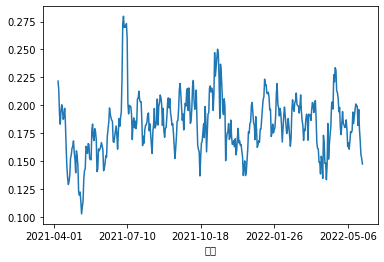

In [32]:
df2['roll'].plot()

In [36]:
df = df[['날짜','댓글','LSTM']]

In [39]:
df2 = df[df['날짜']>='2022-05-19']
df2

,날짜,댓글,LSTM
0,2022-05-26,30 평단 언제 올까,0.0075
1,2022-05-26,최고가에 못팔아 먹더니?,1.0000
2,2022-05-26,내평단,0.0006
3,2022-05-26,26년차)벌써 한장 벌고 있데이~♡,0.0012
4,2022-05-26,잠시나마.,0.0029
...,...,...,...
1124,2022-05-19,시초가 25만원,0.0020
1125,2022-05-19,덕유산에서 내려 왔습니다,0.0006
1126,2022-05-19,수연아,0.0006
1127,2022-05-19,수연이 쓰,0.0001


In [41]:
def BERT_feargreed(df):
    raw_comment_list = df['댓글'].to_list()
    pred_list=[]
    for i in raw_comment_list:
        f = classifier(i)[0][0]['score']
        g = classifier(i)[0][1]['score']
        if f >= g:
            pred_list.append(1-f)
        else:
            pred_list.append(g)
        print(f'\rBERT 댓글{len(pred_list)}개 분석중..',end='')  
    return pred_list
df2['BERT'] = BERT_feargreed(df2)

BERT 댓글1129개 분석중..

In [42]:
df3 = df2.groupby(df2['날짜']).mean()
df3

,LSTM,BERT
날짜,,
2022-05-19,0.167612,0.350070
2022-05-20,0.157472,0.380217
2022-05-21,0.160081,0.292723
2022-05-22,0.046864,0.306743
2022-05-23,0.190069,0.434465
2022-05-24,0.175247,0.337712
2022-05-25,0.171617,0.337624
2022-05-26,0.131653,0.447316
